# Imports

In [1]:
import sys
import os
import cPickle as pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

gleam_root = "/Users/phdenzel/gleam"
sys.path.append(gleam_root)
import gleam
from gleam.multilens import MultiLens
from gleam.utils.lensing import LensModel
from gleam.reconsrc import ReconSrc
from gleam.lightsampler import LightSampler
from gleam.starsampler import StarSampler
from gleam.utils.lensing import kappa_profile
from gleam.utils.lensing import enc_profile
from gleam.utils.lensing import dispersion_profile
# from gleam.utils.lensing import encmass_profile, enc_profile
from gleam.utils.plotting import kappa_map_plot, kappa_profiles_plot
from gleam.utils.plotting import arrival_time_surface_plot
from gleam.utils.plotting import plot_scalebar, plot_labelbox
from gleam.utils.rgb_map import lupton_like, grayscale
import gleam.utils.units as glu
import gleam.utils.colors as gcl


In [2]:
extension = 'pdf'


# Lens models

In [3]:
statefile = 'gls/012771.state'
# statefile = 'gls/N7LTELSYTM.state'
# statefile = 'gls/sw05.state'
print(statefile)


gls/012771.state


In [4]:
lm = LensModel(statefile)
print(lm.__v__)


filename            	012771.state
filepath            	gls/012771.state
N                   	200
pixrad              	12
maprad              	8.52937665444
pixel_size          	0.227450044118
kappa               	55659503266.0
minima              	[[ 1.347  5.29 ]
 [-4.249 -2.3  ]]
saddle_points       	[[-4.68  -0.238]
 [ 2.472 -2.252]]
maxima              	[]
zl                  	0.66
zs                  	3.0
N_obj               	1
N_src               	1
obj_idx             	0
src_idx             	0


## Lens observations

In [5]:
lensfiles = !ls data/*.fits
key_sorter = {'U': 0, 'G': 1, 'R': 2, 'I': 3, 'I2': 4, 'Z': 5}
lensfiles = sorted(lensfiles, key=lambda f: key_sorter[f.split('.')[1]])
print(lensfiles)


['data/W3+3-2.U.12909_13036_7445_7572.fits', 'data/W3+3-2.G.12909_13036_7445_7572.fits', 'data/W3+3-2.R.12909_13036_7445_7572.fits', 'data/W3+3-2.I.12909_13036_7445_7572.fits', 'data/W3+3-2.I2.12909_13036_7445_7572.fits', 'data/W3+3-2.Z.12909_13036_7445_7572.fits']


In [6]:
ml = MultiLens(lensfiles)
ml['i'].data = np.flipud(ml['i'].data[:])
for b in ml.bands:
    ml[b].zl = lm.zl
    ml[b].zs = lm.zs
print(ml.__v__)


N                   	6
filepaths           	['/Users/phdenzel/sw05/data/W3+3-2.U.12909_13036_7445_7572.fits', '/Users/phdenzel/sw05/data/W3+3-2.G.12909_13036_7445_7572.fits', '/Users/phdenzel/sw05/data/W3+3-2.R.12909_13036_7445_7572.fits', '/Users/phdenzel/sw05/data/W3+3-2.I.12909_13036_7445_7572.fits', '/Users/phdenzel/sw05/data/W3+3-2.I2.12909_13036_7445_7572.fits', '/Users/phdenzel/sw05/data/W3+3-2.Z.12909_13036_7445_7572.fits']
files               	['W3+3-2.U.12909_13036_7445_7572.fits', 'W3+3-2.G.12909_13036_7445_7572.fits', 'W3+3-2.R.12909_13036_7445_7572.fits', 'W3+3-2.I.12909_13036_7445_7572.fits', 'W3+3-2.I2.12909_13036_7445_7572.fits', 'W3+3-2.Z.12909_13036_7445_7572.fits']
fs                  	[LensObject(u@[218.7258, 52.4808]), LensObject(g@[218.7258, 52.4808]), LensObject(r@[218.7258, 52.4808]), LensObject(i@[218.7258, 52.4808]), LensObject(i@[218.7258, 52.4808]), LensObject(z@[218.7258, 52.4808])]
bands               	['u', 'g', 'r', 'i', 'i', 'z']
naxis1              	[1

In [7]:
best_pars = {'x': 59.02099903821723, 'y': 58.9346344410624,
             'I_0': 29.49507094039217,
             'n': 1.4974741188141885, 'c_0': 0.0,
             'e': 0.11663097506313133,
             'phi': 3.464562637198838+90,
             'r_s': 8.976805452180514 * (100./128),
}
lsampler = LightSampler.from_gleamobj(ml, verbose=0)
lsampler.parameters = best_pars
ml['i'].light_model = lsampler.model
print lsampler.parameters


{'phi': 93.46456263719884, 'e': 0.11663097506313133, 'r_s': 7.013129259516027, 'n': 1.4974741188141885, 'c_0': 0.0, 'y': 58.9346344410624, 'x': 59.02099903821723, 'I_0': 29.49507094039217}


In [8]:
# from MCMC (hardcoded, resampling would take too long)
m_stel = [3.04e+11 - 5*0.22e+11, 3.04e+11, 3.04e+11 + 5*0.22e+11]
print(m_stel)
ml['i'].stel_mass = m_stel[1]
print "{:e}".format(m_stel[1])

[194000000000.0, 304000000000.0, 414000000000.0]
3.040000e+11


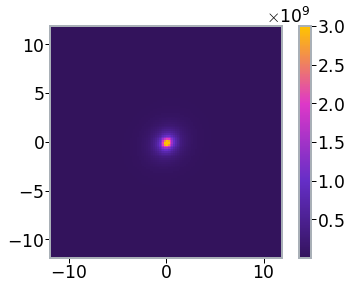

In [9]:
# lower limit
ml['i'].stel_mass = m_stel[0]
stelmin_map = ml['i'].stel_map
# upper limit
ml['i'].stel_mass = m_stel[2]
stelmax_map = ml['i'].stel_map
# median
ml['i'].stel_mass = m_stel[1]
stel_map = ml['i'].stel_map

pxkpc = ml['i'].px2arcsec[0]*lm.arcsec2kpc[-1]
_, stel_pmin = enc_profile(stelmin_map)
_, stel_pmax = enc_profile(stelmax_map)
rad, stel_prf = enc_profile(stel_map)
stel_rad = rad * pxkpc

plt.imshow(stel_map, cmap='phoenix', extent=ml['i'].extent, vmax=3e+9)
plt.colorbar()



## Profiling

In [10]:
def halflight_radius(R, M):
    """
    Get interpolated halflight radius with neighboring indices
    from lists of masses and radii
    """
    halflM = 0.5*M[-1]
    idx = np.argmin(np.abs(M - halflM))
    if M[idx+1] > halflM > M[idx]:
        x1 = M[idx+1]
        y1 = R[idx+1]
        x0 = M[idx]
        y0 = R[idx]
        x = halflM
        idx0 = idx
        idx1 = idx+1
    else:
        x1 = M[idx]
        y1 = R[idx]
        x0 = M[idx-1]
        y0 = R[idx-1]
        x = halflM
        idx0 = idx-1
        idx1 = idx
    halfR_lerp = y0*(1-(x-x0)/(x1-x0))+y1*((x-x0)/(x1-x0))
    return halfR_lerp, (idx0, idx1)



In [11]:
def idkey_remap(key):
    if key == 'TL00003 (z=0.6)':
        return 'C1'
    elif key == 'TL00113 (z=0.5)':
        return 'A4'
    elif key == 'TL00206 (z=0.5)':
        return 'A1'
    elif key == 'TL00017 (z=0.6)':
        return 'D7'


def idkey_redsh(key):
    if key == 'TL00003 (z=0.6)':
        return 0.6
    elif key == 'TL00113 (z=0.5)':
        return 0.5
    elif key == 'TL00206 (z=0.5)':
        return 0.5
    elif key == 'TL00017 (z=0.6)':
        return 0.6

In [12]:
firefiles = {
    'TL00003 (z=0.6)': 'savestates/fire/B100_N512_M3e13_TL00003_baryon_toz0_LR_9915.z0.600.AHF_profiles.pkl',
    'TL00113 (z=0.5)': 'savestates/fire/B100_N512_TL00113_baryon_toz0_9915.z0.510.AHF_profiles.pkl',
    'TL00206 (z=0.5)': 'savestates/fire/B100_N512_TL00206_baryon_toz0_9915.z0.510.AHF_profiles.pkl',
    'TL00017 (z=0.6)': 'savestates/fire/B100_N512_z0_13.5_TL00017_baryon_toz0_9915.z0.600.AHF_profiles.pkl',
}

In [13]:
fire_profs = {}
for k in firefiles:
    with open(firefiles[k], 'rb') as f:
        dta = pickle.load(f)
        fire_profs[k] = dta


In [14]:
# sanitize
for k in firefiles:
    dta = fire_profs[k]
    dta[1] = np.array([d if dta[1][max(i-1, 0)] < d else dta[1][max(i-1, 0)] for i, d in enumerate(dta[1])])
    dta[2] = np.array([d if dta[2][max(i-1, 0)] < d else dta[2][max(i-1, 0)] for i, d in enumerate(dta[1])])
    fire_profs[k] = dta[:]
    

In [15]:
# Correct the comoving distances
fire_profs_comov = {}
hmult = lambda x: x/0.72
hmultprprd = lambda x: x/0.72/(1+z)
for k in fire_profs:
    z = idkey_redsh(k)
    dta = fire_profs[k]
    # correct h factor: H_0 = h * 100 km/s/Mpc; vanilla cosmology: h~0.72
    # comoving coordinates/(1+z) = angular coords (as long as omega_k = 0)
    fire_profs_comov[k] = [map(hmultprprd, dta[0]),
                           map(hmult, dta[1]),
                           map(hmult, dta[2])]

In [16]:
# Rescale FIRE halos


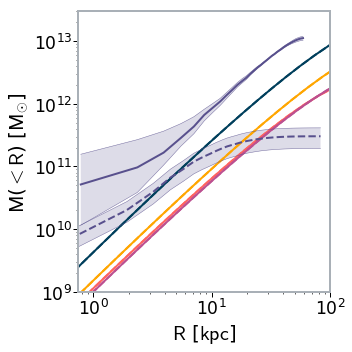

In [17]:
plt.figure(figsize=(5, 5))

palette = gcl.GLEAMcolors.pl5
clrsw05 = palette[-2]
palette = palette[:-2] + palette[-1:]
for k, c in zip(fire_profs_comov, palette):
    dta = fire_profs[k]
    # dark halo
    plt.loglog(dta[0], dta[1], c=c, ls='-', lw=2, label=idkey_remap(k))
    # stellar matter
    plt.loglog(dta[0], dta[2], c=c, ls='--', lw=2)

# lens
rad, prf, pmin, pmax = lm.encmass_profile_range(refined=True, runit='kpc')
plt.loglog(rad, prf, lw=2, color=clrsw05, label='SW05')
plt.fill_between(rad, pmax, pmin, facecolor=clrsw05, alpha=0.2)
plt.loglog(rad, pmin, lw=0.5, color=clrsw05, alpha=0.8)
plt.loglog(rad, pmax, lw=0.5, color=clrsw05, alpha=0.8)

# stellar mass
plt.loglog(stel_rad, stel_prf, lw=2, ls='--', color=clrsw05, label=r'$\bigstar$ SW05')
plt.fill_between(stel_rad, stel_pmax, stel_pmin, facecolor=clrsw05, alpha=0.2)
plt.loglog(stel_rad, stel_pmin, lw=0.5, color=clrsw05, alpha=0.8)
plt.loglog(stel_rad, stel_pmax, lw=0.5, color=clrsw05, alpha=0.8)

plt.xlim(0.75, 100)
plt.ylim(1e9, 3e13)
plt.xlabel(r'$\mathsf{R}$ [$\mathsf{kpc}$]', fontsize=20)
plt.ylabel(r'$\mathsf{M}$($\mathsf{<R}$) [$\mathsf{M_{\odot}}$]', fontsize=20)
# plt.legend()
plt.tight_layout()

savename = 'profiles_SW05_wFIRE.{}'.format(extension)
plt.savefig(os.path.join('plots', savename),
            transparent=True, bbox_inches='tight', pad_inches=0)

In [18]:
from gleam.glass_interface import glass_renv
glass = glass_renv()

print "dL \t", lm.dl
print "dlsds\t", lm.dlsds
print "H0 \t", lm.H0[-1]
print "nu \t", lm.nu[-1]
print "kpc\t", lm.arcsec2kpc[-1]
print "kappa\t", lm.kappa

dL 	0.33890035574521704
dlsds	0.6284988144965584
H0 	71.37328467153284
nu 	3.1054927171532847
kpc	6.90477372043063
kappa	55659503266.029175
